<a href="https://colab.research.google.com/github/Jzakai/computer-vision/blob/main/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

# Finetuning

1. Downloaded pretrained Resnet18 model from torchhub
2. Modified the model for object 101 dataset subset
3. Split the dataset between training and validation set (80% / 20%).
4. Fine tuned the model for classification on the dataset.


In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28))# hint: Is something missing?
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
print(len(image_dataset))

9144


In [ ]:
img, label = image_dataset[50]
print(f'{label=}')
transforms.functional.to_pil_image(img)

label=0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
split = int(0.8 * len(image_dataset))
indices = list(range(len(image_dataset)))
train_indices,test_indices = indices[:split], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(image_dataset, batch_size=32,sampler=train_sampler)
test_loader = DataLoader(image_dataset, batch_size=32,sampler=test_sampler)



In [ ]:
from torchvision import models,transforms
device=torch.device("cuda:0")

#get resnet
net=models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.6MB/s]


In [ ]:
#freeze all layers
for params in net.parameters():
  params.requirs_grad=False

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
net.fc=nn.Linear(in_features=512,out_features=102,bias=True)
# select desired output in out_features =101

In [ ]:
net=net.to(device)

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Adjusting learning rate of group 0 to 8.1000e-03.


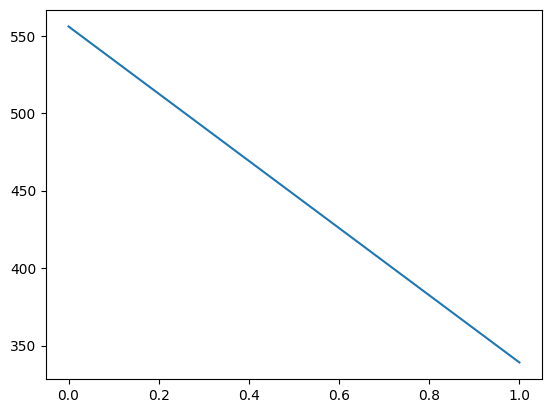

In [ ]:
#training
import torch.nn as nn
import torch.optim as optim

num_epochs=2
opt=optim.SGD(net.parameters(),lr=1e-2,momentum=0.5)
lr_sch=optim.lr_scheduler.ExponentialLR(opt,0.9,verbose=True) #verbose:to see the printed updates
ls=[]
for _ in range(num_epochs):
  total_loss=0

  for batch in train_loader:
    x,y=batch[0].to(device),batch[1].to(device)
    yhat=net(x)
    loss=F.cross_entropy(yhat,y)
    total_loss+=loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
  lr_sch.step()
plt.plot(ls)

In [ ]:
#UnfreeZe
for params in net.parameters():
  params.requirs_grad=False

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Adjusting learning rate of group 0 to 8.1000e-03.


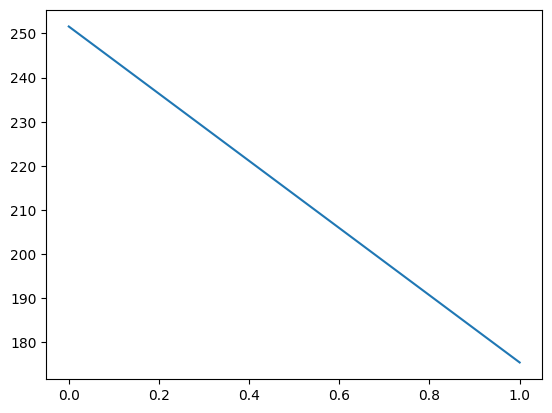

In [ ]:
#training again
import torch.optim as optim
num_epochs=2
opt=optim.SGD(net.parameters(),lr=1e-2,momentum=0.5)
lr_sch=optim.lr_scheduler.ExponentialLR(opt,0.9,verbose=True) #verbose:to see the printed updates
ls=[]
for _ in range(num_epochs):
  total_loss=0

  for batch in train_loader:
    x,y=batch[0].to(device),batch[1].to(device)
    yhat=net(x)
    loss=F.cross_entropy(yhat,y)
    total_loss+=loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
  lr_sch.step()
plt.plot(ls)

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for batch in test_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    pred = torch.argmax(logits, dim=1)
    correct += (pred == y).sum().item()
    total += y.size(0)
  print(f"Accuracy of Model: {100 * correct / total:.2f}%")

Accuracy of Model: 86.89%


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of Model: 85.74%
[[415   0   1 ...   0   0   2]
 [  5 424   0 ...   0   0   0]
 [  0   4 426 ...   0   0   0]
 ...
 [  0   0   0 ...  44   0   0]
 [  1   1   0 ...   0  30   0]
 [  1   0   0 ...   0   0  25]]


NameError: name 'np' is not defined

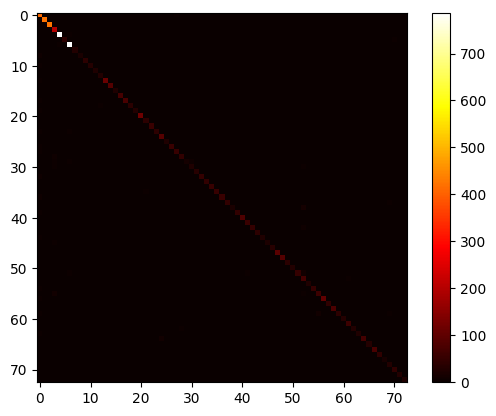

In [ ]:
# prompt: create confusion matrix and plot

from sklearn.metrics import confusion_matrix
with torch.no_grad():
  correct = 0
  total = 0
  y_pred = []
  y_true = []
  for batch in test_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    pred = torch.argmax(logits, dim=1)
    correct += (pred == y).sum().item()
    total += y.size(0)
    y_pred.extend(pred.cpu().numpy())
    y_true.extend(y.cpu().numpy())
  print(f"Accuracy of Model: {100 * correct / total:.2f}%")

cm = confusion_matrix(y_true, y_pred)
print(cm)
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(102)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
